Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
COLLABORATORS = "Michael Fridkin, Hamid S, Em Baez Abreu"

---

## Analysis Code

This is the notebook you should submit with your analysis code.

In [1]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
df_essay = pd.read_csv('A3CleanedEssayData.csv')



In [7]:
df_essay['authorship'].value_counts()

authorship
Entirely written by me                            115
AI-generated                                      108
Partly written by me, partly by AI                 52
Written by me, but grammar was corrected by AI     34
Name: count, dtype: int64

In [8]:
keep_mask = df_essay['authorship'].isin(["Entirely written by me", "AI-generated"])

df_clean = df_essay[keep_mask].copy()

authorship_mapping = { "Entirely written by me": 0, "AI-generated": 1, }

df_clean['y_true'] = df_clean['authorship'].map(authorship_mapping)

print(df_clean['authorship'].value_counts())
print("\nPrevalence of AI essays:", df_clean['y_true'].mean())
df_clean[['authorship', 'y_true']].head()


authorship
Entirely written by me    115
AI-generated              108
Name: count, dtype: int64

Prevalence of AI essays: 0.484304932735426


,authorship,y_true
0,Entirely written by me,0
1,Entirely written by me,0
3,Entirely written by me,0
5,AI-generated,1
6,Entirely written by me,0


In [9]:
detector_score_cols = {"gptzero": "gptzero_ai_percent", 
                       "contentdetector": "contentdetector_ai_percent",
                       "sapling": "sapling_fake_percent",
                       "copyleaks": "copyleaks_ai_percent",
                      }

for det_name, col in detector_score_cols.items():
    s = pd.to_numeric(df_clean[col], errors='coerce')
    df_clean[f"{det_name}_prob_ai"] = s / 100.0

df_clean[[c for c in df_clean.columns if c.endswith("_prob_ai")]].head()

,gptzero_prob_ai,contentdetector_prob_ai,sapling_prob_ai,copyleaks_prob_ai
0,0.0,0.25,0.001,0.0
1,0.0,0.00,0.000,0.0
3,0.0,0.48,0.003,0.0
5,0.0,0.00,0.778,0.0
6,0.0,0.60,0.105,0.0


In [ ]:
evaluation metrics

In [10]:
import numpy as np

In [11]:
def confusion_counts(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))

    return {"TP": tp, "FP": fp, "FN": fn, "TN": tn}

In [12]:
def accuracy(cm):
    tp, fp, fn, tn = cm["TP"], cm["FP"], cm["FN"], cm["TN"]
    total = tp + fp + fn + tn
    return (tp + tn) / total if total > 0 else np.nan

In [13]:
def ppv(cm):
    tp, fp = cm["TP"], cm["FP"]
    return tp / (tp + fp) if (tp + fp) > 0 else np.nan

In [14]:
def npv(cm):
    fn, tn = cm["FN"], cm["TN"]
    return tn / (tn + fn) if (tn + fn) > 0 else np.nan

In [15]:
def tpr(cm):
    tp, fn = cm["TP"], cm["FN"]
    return tp / (tp + fn) if (tp + fn) > 0 else np.nan

In [16]:
def tnr(cm):
    fp, tn = cm["FP"], cm["TN"]
    return tn / (tn + fp) if (tn + fp) > 0 else np.nan

In [17]:
def all_metrics(cm):
    return{
        "Accuracy": accuracy(cm),
        "PPV": ppv(cm),
        "NPV": npv(cm),
        "TPR": tpr(cm),
        "TNR": tnr(cm),
        "TP": cm["TP"],
        "FP": cm["FP"],
        "FN": cm["FN"],
        "TN": cm["TN"],
    }

In [18]:
def evaluate_detector_at_threshold(y_true, prob_ai, threshold = 0.5):
    y_pred = (prob_ai >= threshold).astype(int)
    cm = confusion_counts(y_true, y_pred)
    return all_metrics(cm)

In [19]:
results_default = {}
for det_name in ["gptzero", "contentdetector", "sapling", "copyleaks"]:
    prob_col = f"{det_name}_prob_ai"
    metrics = evaluate_detector_at_threshold(df_clean['y_true'], df_clean[prob_col], threshold = 0.5)
    results_default[det_name] = metrics

results_default_df = pd.DataFrame(results_default).T
results_default_df

,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN
gptzero,0.896861,0.929293,0.870968,0.851852,0.939130,92.0,7.0,16.0,108.0
contentdetector,0.681614,0.676190,0.686441,0.657407,0.704348,71.0,34.0,37.0,81.0
sapling,0.784753,0.708333,0.924051,0.944444,0.634783,102.0,42.0,6.0,73.0
copyleaks,0.892377,0.875000,0.909910,0.907407,0.878261,98.0,14.0,10.0,101.0


In [20]:
def threshold_sweep(y_true, prob_ai, thresholds):
    rows = []
    for th in thresholds:
        y_pred = (prob_ai >= th).astype(int)
        cm = confusion_counts(y_true, y_pred)
        m = all_metrics(cm)
        m["threshold"] = th
        rows.append(m)
    return pd.DataFrame(rows)

In [21]:
thresholds_dict = {
    "gptzero": [0.5, 0.87],
    "contentdetector": [0.5, 0.75],
    "sapling": [0.5, 0.87],
    "copyleaks": [0.5, 0.85],
}

threshold_results = []
for det_name, th_list in thresholds_dict.items():
    prob_col = f"{det_name}_prob_ai"
    df_sweep = threshold_sweep(df_clean['y_true'], df_clean[prob_col], th_list)
    df_sweep["detector"] = det_name
    threshold_results.append(df_sweep)

all_threshold_results = pd.concat(threshold_results, ignore_index=True)
all_threshold_results

,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN,threshold,detector
0,0.896861,0.929293,0.870968,0.851852,0.939130,92,7,16,108,0.50,gptzero
1,0.878924,0.965517,0.823529,0.777778,0.973913,84,3,24,112,0.87,gptzero
2,0.681614,0.676190,0.686441,0.657407,0.704348,71,34,37,81,0.50,contentdetector
3,0.650224,0.788462,0.608187,0.379630,0.904348,41,11,67,104,0.75,contentdetector
4,0.784753,0.708333,0.924051,0.944444,0.634783,102,42,6,73,0.50,sapling
5,0.843049,0.806723,0.884615,0.888889,0.800000,96,23,12,92,0.87,sapling
6,0.892377,0.875000,0.909910,0.907407,0.878261,98,14,10,101,0.50,copyleaks
7,0.887892,0.895238,0.881356,0.870370,0.904348,94,11,14,104,0.85,copyleaks


In [22]:
for det_name in ["gptzero", "contentdetector", "sapling", "copyleaks"]:
    print(f"\n=== {det_name} ===")
    sub = all_threshold_results[all_threshold_results["detector"] == det_name]
    display(sub[["threshold", "Accuracy", "PPV", "NPV", "TPR", "TNR", "TP", "FP", "FN", "TN"]])


=== gptzero ===


,threshold,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN
0,0.50,0.896861,0.929293,0.870968,0.851852,0.939130,92,7,16,108
1,0.87,0.878924,0.965517,0.823529,0.777778,0.973913,84,3,24,112



=== contentdetector ===


,threshold,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN
2,0.50,0.681614,0.676190,0.686441,0.657407,0.704348,71,34,37,81
3,0.75,0.650224,0.788462,0.608187,0.379630,0.904348,41,11,67,104



=== sapling ===


,threshold,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN
4,0.50,0.784753,0.708333,0.924051,0.944444,0.634783,102,42,6,73
5,0.87,0.843049,0.806723,0.884615,0.888889,0.800000,96,23,12,92



=== copyleaks ===


,threshold,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN
6,0.50,0.892377,0.875000,0.909910,0.907407,0.878261,98,14,10,101
7,0.85,0.887892,0.895238,0.881356,0.870370,0.904348,94,11,14,104


In [23]:
det_name = "gptzero"
metrics = results_default[det_name]
tpr_val = metrics["TPR"]
tnr_val = metrics["TNR"]
tpr_val, tnr_val

(0.8518518518518519, 0.9391304347826087)

In [24]:
def ppv_given_prevalence(tpr_val, tnr_val, prevalence):
    pi = prevalence
    return (tpr_val * pi) / (tpr_val * pi + (1 - tnr_val) * (1 - pi))

def npv_given_prevalence(tpr_val, tnr_val, prevalence):
    pi = prevalence
    return (tnr_val * (1 - pi)) / (tnr_val * (1 - pi) + (1 - tpr_val) * pi)

In [25]:
prevalences = np.linspace(0.01, 0.99, 20)
rows = []
for pi in prevalences:
    rows.append({
        "prevalence": pi, 
        "PPV": ppv_given_prevalence(tpr_val, tnr_val, pi),
        "NPV": npv_given_prevalence(tpr_val, tnr_val, pi),
    })

df_prev = pd.DataFrame(rows)
df_prev

,prevalence,PPV,NPV
0,0.010000,0.123853,0.998409
1,0.061579,0.478713,0.989755
2,0.113158,0.641021,0.980269
3,0.164737,0.734053,0.969826
4,0.216316,0.794360,0.958274
5,0.267895,0.836628,0.945426
6,0.319474,0.867897,0.931050
7,0.371053,0.891965,0.914858
8,0.422632,0.911064,0.896481
9,0.474211,0.926589,0.875446


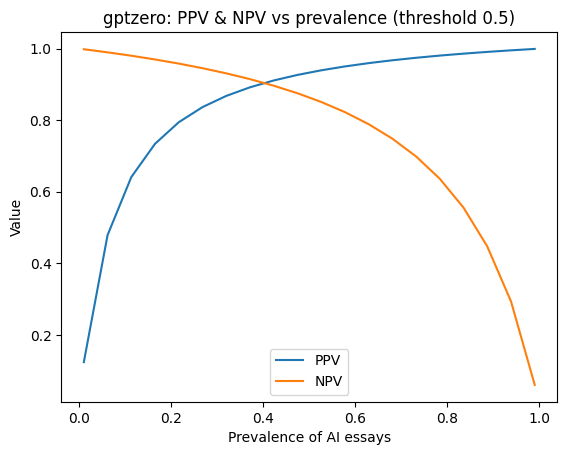

In [26]:
plt.figure()
plt.plot(df_prev["prevalence"], df_prev["PPV"], label="PPV")
plt.plot(df_prev["prevalence"], df_prev["NPV"], label="NPV")
plt.xlabel("Prevalence of AI essays")
plt.ylabel("Value")
plt.title(f"{det_name}: PPV & NPV vs prevalence (threshold 0.5)")
plt.legend()
plt.show()

In [52]:
overall_results = []
for det_name in ['gptzero', 'contentdetector', 'sapling', 'copyleaks']:
    prob_col = f"{det_name}_prob_ai"
    metrics = evaluate_detector_at_threshold(df_clean['y_true'], df_clean[prob_col], threshold=0.5)
    metrics['detector'] = det_name
    overall_results.append(metrics)

overall_df = pd.DataFrame(overall_results)

print("OVERALL PERFORMANCE (All Essays)")
display(overall_df[['detector', 'Accuracy', 'PPV', 'NPV', 'TPR', 'TNR', 'FP', 'FN']].round(3))

OVERALL PERFORMANCE (All Essays)


,detector,Accuracy,PPV,NPV,TPR,TNR,FP,FN
0,gptzero,0.897,0.929,0.871,0.852,0.939,7,16
1,contentdetector,0.682,0.676,0.686,0.657,0.704,34,37
2,sapling,0.785,0.708,0.924,0.944,0.635,42,6
3,copyleaks,0.892,0.875,0.910,0.907,0.878,14,10


In [53]:
# Prediction Fairness & Simpson's Paradox Analysis


In [54]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [55]:
print("\n1. Class Type Distribution:")
print(df_clean['class_type'].value_counts())

print("\n2. Grade Distribution:")
print(df_clean['grade_letter'].value_counts())

# Create simplified class category
humanities = ['English', 'History', 'Ethics']
stem = ['Technology']

def categorize_class(class_type):
    if pd.isna(class_type):
        return 'Other'
    elif class_type in humanities:
        return 'Humanities'
    elif class_type in stem:
        return 'STEM'
    else:
        return 'Other'

df_clean['class_category'] = df_clean['class_type'].apply(categorize_class)

print("\n3. Class Category Distribution (Simplified):")
print(df_clean['class_category'].value_counts())

print("\n4. Distribution by Authorship and Class Category:")
print(pd.crosstab(df_clean['authorship'], df_clean['class_category']))


1. Class Type Distribution:
class_type
Other         74
English       61
History       45
Technology    24
Ethics        15
Economics      4
Name: count, dtype: int64

2. Grade Distribution:
grade_letter
A    75
B    34
C     4
Name: count, dtype: int64

3. Class Category Distribution (Simplified):
class_category
Humanities    121
Other          78
STEM           24
Name: count, dtype: int64

4. Distribution by Authorship and Class Category:
class_category          Humanities  Other  STEM
authorship                                     
AI-generated                    46     48    14
Entirely written by me          75     30    10


In [56]:
#Compute metrics by subgroup

In [57]:
def compute_metrics_by_group(df, group_col, detectors=['gptzero', 'contentdetector', 'sapling', 'copyleaks'], threshold=0.5):

    results = []
    
    for group_val in df[group_col].dropna().unique():
        group_df = df[df[group_col] == group_val]
        
        # Skip very small groups or groups without both classes
        if len(group_df) < 10 or group_df['y_true'].nunique() < 2:
            continue
        
        for det_name in detectors:
            prob_col = f"{det_name}_prob_ai"
            
            # Skip if too many missing values
            if group_df[prob_col].isna().sum() > len(group_df) * 0.5:
                continue
            
            metrics = evaluate_detector_at_threshold(
                group_df['y_true'].values,
                group_df[prob_col].values,
                threshold=threshold
            )
            
            metrics['detector'] = det_name
            metrics['group_type'] = group_col
            metrics['group_value'] = group_val
            metrics['n_samples'] = len(group_df)
            metrics['n_ai'] = int(group_df['y_true'].sum())
            metrics['n_human'] = int(len(group_df) - group_df['y_true'].sum())
            metrics['prevalence'] = group_df['y_true'].mean()
            
            results.append(metrics)
    
    return pd.DataFrame(results)
print("done")

done


In [58]:
class_metrics = compute_metrics_by_group(df_clean, 'class_type')

if len(class_metrics) > 0:
    print("\nKey Metrics by Class Type:")
    display(class_metrics[['detector', 'group_value', 'n_samples', 'n_human', 'n_ai', 'prevalence', 
                            'Accuracy', 'TPR', 'TNR', 'FP', 'FN']].round(3))
else:
    print("Not enough data for class type analysis")


Key Metrics by Class Type:


,detector,group_value,n_samples,n_human,n_ai,prevalence,Accuracy,TPR,TNR,FP,FN
0,gptzero,English,61,46,15,0.246,0.951,0.867,0.978,1,2
1,contentdetector,English,61,46,15,0.246,0.820,0.867,0.804,9,2
2,sapling,English,61,46,15,0.246,0.820,1.000,0.761,11,0
3,copyleaks,English,61,46,15,0.246,0.951,0.867,0.978,1,2
4,gptzero,Ethics,15,9,6,0.400,0.933,1.000,0.889,1,0
5,contentdetector,Ethics,15,9,6,0.400,0.667,0.833,0.556,4,1
6,sapling,Ethics,15,9,6,0.400,0.800,1.000,0.667,3,0
7,copyleaks,Ethics,15,9,6,0.400,0.733,0.833,0.667,3,1
8,gptzero,History,45,20,25,0.556,0.844,0.760,0.950,1,6
9,contentdetector,History,45,20,25,0.556,0.444,0.360,0.550,9,16


In [59]:

category_metrics = compute_metrics_by_group(df_clean, 'class_category')

if len(category_metrics) > 0:
    print("\nKey Metrics by Class Category:")
    display(category_metrics[['detector', 'group_value', 'n_samples', 'n_human', 'n_ai', 'prevalence',
                               'Accuracy', 'TPR', 'TNR', 'FP', 'FN']].round(3))
else:
    print("Not enough data for category analysis")


Key Metrics by Class Category:


,detector,group_value,n_samples,n_human,n_ai,prevalence,Accuracy,TPR,TNR,FP,FN
0,gptzero,Humanities,121,75,46,0.380,0.909,0.826,0.960,3,8
1,contentdetector,Humanities,121,75,46,0.380,0.661,0.587,0.707,22,19
2,sapling,Humanities,121,75,46,0.380,0.810,0.957,0.720,21,2
3,copyleaks,Humanities,121,75,46,0.380,0.893,0.848,0.920,6,7
4,gptzero,Other,78,30,48,0.615,0.846,0.833,0.867,4,8
5,contentdetector,Other,78,30,48,0.615,0.744,0.750,0.733,8,12
6,sapling,Other,78,30,48,0.615,0.744,0.917,0.467,16,4
7,copyleaks,Other,78,30,48,0.615,0.872,0.938,0.767,7,3
8,gptzero,STEM,24,10,14,0.583,1.000,1.000,1.000,0,0
9,contentdetector,STEM,24,10,14,0.583,0.583,0.571,0.600,4,6


In [60]:
## Prediction Bias Analysis

In [61]:
# Use whichever grouping has the most data
if len(class_metrics) > 0:
    main_metrics = class_metrics
    group_name = 'class_type'
elif len(category_metrics) > 0:
    main_metrics = category_metrics
    group_name = 'class_category'
else:
    main_metrics = grade_metrics
    group_name = 'grade_letter'

print(f"\nAnalyzing bias across: {group_name}\n")

print("1. FALSE POSITIVE RATES (Human essays incorrectly flagged as AI)")


fpr_pivot = main_metrics.pivot(index='detector', columns='group_value', values='FP')
print("\nFP by Group:")
display(fpr_pivot.round(3))

print("\nFPR Statistics by Detector:")
fpr_stats = pd.DataFrame({
    'Mean FP': fpr_pivot.mean(axis=1),
    'Std FP': fpr_pivot.std(axis=1),
    'Min FP': fpr_pivot.min(axis=1),
    'Max FP': fpr_pivot.max(axis=1),
    'Range': fpr_pivot.max(axis=1) - fpr_pivot.min(axis=1)
})
display(fpr_stats.round(3))

print("2. FALSE NEGATIVE RATES (AI essays incorrectly flagged as Human)")

fnr_pivot = main_metrics.pivot(index='detector', columns='group_value', values='FN')
print("\nFNR by Group:")
display(fnr_pivot.round(3))

print("\nFNR Statistics by Detector:")
fnr_stats = pd.DataFrame({
    'Mean FN': fnr_pivot.mean(axis=1),
    'Std FN': fnr_pivot.std(axis=1),
    'Min FN': fnr_pivot.min(axis=1),
    'Max FN': fnr_pivot.max(axis=1),
    'Range': fnr_pivot.max(axis=1) - fnr_pivot.min(axis=1)
})
display(fnr_stats.round(3))

print("3. GROUPS MOST AFFECTED BY BIAS")


for detector in ['gptzero', 'contentdetector', 'sapling', 'copyleaks']:
    detector_data = main_metrics[main_metrics['detector'] == detector]
    if len(detector_data) > 0:
        max_fpr_row = detector_data.loc[detector_data['FP'].idxmax()]
        min_fpr_row = detector_data.loc[detector_data['FP'].idxmin()]
        
        print(f"\n{detector.upper()}:")
        print(f"  Highest FPR: {max_fpr_row['group_value']} (FPR={max_fpr_row['FP']:.3f})")
        print(f"  Lowest FPR:  {min_fpr_row['group_value']} (FPR={min_fpr_row['FP']:.3f})")
        if min_fpr_row['FP'] > 0:
            ratio = max_fpr_row['FP'] / min_fpr_row['FP']
            print(f"  Disparity:   {ratio:.2f}x higher risk for {max_fpr_row['group_value']}")


Analyzing bias across: class_type

1. FALSE POSITIVE RATES (Human essays incorrectly flagged as AI)

FP by Group:


group_value,English,Ethics,History,Other,Technology
detector,,,,,
contentdetector,9,4,9,8,4
copyleaks,1,3,2,7,1
gptzero,1,1,1,4,0
sapling,11,3,7,15,5



FPR Statistics by Detector:


,Mean FP,Std FP,Min FP,Max FP,Range
detector,,,,,
contentdetector,6.8,2.588,4,9,5
copyleaks,2.8,2.490,1,7,6
gptzero,1.4,1.517,0,4,4
sapling,8.2,4.817,3,15,12


2. FALSE NEGATIVE RATES (AI essays incorrectly flagged as Human)

FNR by Group:


group_value,English,Ethics,History,Other,Technology
detector,,,,,
contentdetector,2,1,16,12,6
copyleaks,2,1,4,3,0
gptzero,2,0,6,8,0
sapling,0,0,2,4,0



FNR Statistics by Detector:


,Mean FN,Std FN,Min FN,Max FN,Range
detector,,,,,
contentdetector,7.4,6.465,1,16,15
copyleaks,2.0,1.581,0,4,4
gptzero,3.2,3.633,0,8,8
sapling,1.2,1.789,0,4,4


3. GROUPS MOST AFFECTED BY BIAS

GPTZERO:
  Highest FPR: Other (FPR=4.000)
  Lowest FPR:  Technology (FPR=0.000)

CONTENTDETECTOR:
  Highest FPR: English (FPR=9.000)
  Lowest FPR:  Ethics (FPR=4.000)
  Disparity:   2.25x higher risk for English

SAPLING:
  Highest FPR: Other (FPR=15.000)
  Lowest FPR:  Ethics (FPR=3.000)
  Disparity:   5.00x higher risk for Other

COPYLEAKS:
  Highest FPR: Other (FPR=7.000)
  Lowest FPR:  English (FPR=1.000)
  Disparity:   7.00x higher risk for Other


In [65]:
#Simpson's Paradox Analysis

In [64]:

# Use category metrics if available, otherwise class metrics
if len(category_metrics) > 0:
    simpson_metrics = category_metrics
    simpson_group = 'class_category'
elif len(class_metrics) > 0:
    simpson_metrics = class_metrics
    simpson_group = 'class_type'
else:
    simpson_metrics = grade_metrics
    simpson_group = 'grade_letter'

print(f"\nChecking for Simpson's Paradox across: {simpson_group}\n")

for detector in ['gptzero', 'contentdetector', 'sapling', 'copyleaks']:
    print(f"{detector.upper()}")
    
    # Overall accuracy
    overall_acc = overall_df[overall_df['detector'] == detector]['Accuracy'].values[0]
    print(f"\nOverall Accuracy: {overall_acc:.3f}")
    
    # Group-specific accuracies
    detector_groups = simpson_metrics[simpson_metrics['detector'] == detector]
    
    if len(detector_groups) > 0:
        print("\nGroup-Specific Accuracies:")
        for _, row in detector_groups.iterrows():
            diff = row['Accuracy'] - overall_acc
            symbol = "X" if diff > 0 else "O" if diff < 0 else "="
            print(f"  {row['group_value']:20s}: {row['Accuracy']:.3f} ({symbol} {diff:+.3f}) [n={int(row['n_samples'])}]")
        
        # Calculate weighted average
        weighted_avg = np.average(
            detector_groups['Accuracy'].values,
            weights=detector_groups['n_samples'].values
        )
        print(f"\nWeighted Average of Groups: {weighted_avg:.3f}")
        print(f"Difference from Overall:    {weighted_avg - overall_acc:+.3f}")
        
        # Check for paradox
        all_higher = all(detector_groups['Accuracy'] > overall_acc)
        all_lower = all(detector_groups['Accuracy'] < overall_acc)
        
        if all_higher:
            print("\n SIMPSON'S PARADOX DETECTED:")
            print("    All groups have HIGHER accuracy than overall!")
        elif all_lower:
            print("\nSIMPSON'S PARADOX DETECTED:")
            print("    All groups have LOWER accuracy than overall!")
        else:
            print("\n  No strong Simpson's Paradox detected")
            print("   (Some groups above, some below overall)")
    else:
        print("  No group data available")


Checking for Simpson's Paradox across: class_category

GPTZERO

Overall Accuracy: 0.897

Group-Specific Accuracies:
  Humanities          : 0.909 (X +0.012) [n=121]
  Other               : 0.846 (O -0.051) [n=78]
  STEM                : 1.000 (X +0.103) [n=24]

Weighted Average of Groups: 0.897
Difference from Overall:    +0.000

  No strong Simpson's Paradox detected
   (Some groups above, some below overall)
CONTENTDETECTOR

Overall Accuracy: 0.682

Group-Specific Accuracies:
  Humanities          : 0.661 (O -0.020) [n=121]
  Other               : 0.744 (X +0.062) [n=78]
  STEM                : 0.583 (O -0.098) [n=24]

Weighted Average of Groups: 0.682
Difference from Overall:    +0.000

  No strong Simpson's Paradox detected
   (Some groups above, some below overall)
SAPLING

Overall Accuracy: 0.785

Group-Specific Accuracies:
  Humanities          : 0.810 (X +0.025) [n=121]
  Other               : 0.744 (O -0.041) [n=78]
  STEM                : 0.792 (X +0.007) [n=24]

Weighted Av

In [ ]:
if len(main_metrics) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # FPR
    fpr_pivot_plot = main_metrics.pivot(index='group_value', columns='detector', values='FP')
    fpr_pivot_plot.plot(kind='bar', ax=axes[0], rot=45, width=0.8)
    axes[0].set_title('False Positive Rate by Group\n(Human essays incorrectly flagged as AI)', 
                      fontsize=13, fontweight='bold')
    axes[0].set_ylabel('False Positive Rate (FP)', fontsize=11)
    axes[0].set_xlabel(group_name.replace('_', ' ').title(), fontsize=11)
    axes[0].legend(title='Detector', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].axhline(y=0.1, color='red', linestyle='--', alpha=0.5, linewidth=1, label='10% threshold')
    
    # FNR
    fnr_pivot_plot = main_metrics.pivot(index='group_value', columns='detector', values='FN')
    fnr_pivot_plot.plot(kind='bar', ax=axes[1], rot=45, width=0.8)
    axes[1].set_title('False Negative Rate by Group\n(AI essays incorrectly flagged as Human)', 
                      fontsize=13, fontweight='bold')
    axes[1].set_ylabel('False Negative Rate (FN)', fontsize=11)
    axes[1].set_xlabel(group_name.replace('_', ' ').title(), fontsize=11)
    axes[1].legend(title='Detector', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].axhline(y=0.1, color='green', linestyle='--', alpha=0.5, linewidth=1, label='10% threshold')
    
    plt.tight_layout()
    plt.savefig('fairness_fpr_fnr_by_group.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: fairness_fpr_fnr_by_group.png")

In [ ]:
# Figure 2: Multi-metric comparison
if len(main_metrics) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    metrics_to_plot = ['Accuracy', 'TPR', 'FP', 'FN']
    titles = ['Accuracy by Group', 'True Positive Rate (Detection Rate)', 
              'False Positive Rate (False Alarm Rate)', 'False Negative Rate (Miss Rate)']
    
    for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[idx // 2, idx % 2]
        metric_pivot = main_metrics.pivot(index='group_value', columns='detector', values=metric)
        metric_pivot.plot(kind='bar', ax=ax, rot=45, width=0.8)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylabel(metric, fontsize=10)
        ax.set_xlabel(group_name.replace('_', ' ').title(), fontsize=10)
        ax.legend(title='Detector', fontsize=8)
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fairness_all_metrics_by_group.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: fairness_all_metrics_by_group.png")